# CEO-Request Challenge

## 1. Summary of Problem Statement

❓ **How could Olist improve its profit** ❓

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL by month** per seller

#### Costs
**Reputation costs** *estimated* per order with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever join the platform, as well as the square root of the total cumulated number of items that were ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that Olist has a lower IT Cost with few sellers selling a lot of items rather than the opposite  
- with **1000 sellers** and a total of **100 items** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 items** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores  
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.  
- The latter being outside of Olist's direct control, improving it is not a quick-win recommendation
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments of the bad reviews showed that some were linked to the seller or to the product itself.

💡 We recommend you to start with the the guided seller analysis in part 2 below  
💪 But feel free to investigate into other hypothesis instead with part 3

## 2. Should Olist remove under-performing sellers from its marketplace? 🕵🏻
*(recommended)*

To analyze the impact of removing the worse sellers from Olist's marketplace, we will perform a **what-if analysis**

👉 **What would have happened if Olist had never accepted these sellers in the first place?**  

*(In practice, it's hard to know in advance who is a good seller, but let's start with this approach and iterate later).*

### 2.1 Data Preparation

Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` it brings
- the `review_costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)

👉 Write down a step-by-step strategy to create the DataFrame you need


⚠️ Don't start from scratch, update your existing package 😉

Starting from the `Seller` class of your `olist` package:

Edit the `get_training_data` method so that the DataFrame it returns contains the fields:
- `revenues`: sum of subscription and sales fees revenues
- `cost_of_reviews`: sum of costs associated with bad reviews
- `profits`: `revenues` - `cost_of_reviews`

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

### 2.2 What-if Analysis

👉 Time to perform the actual analysis, here are our steps:  

1️⃣ Create a method that will help us update the IT Costs after removing sellers along with the items they sold

2️⃣ Sort sellers by increasing profits

3️⃣ Remove sellers one by one, starting from the one with the lowest profit.
- For each number of sellers to remove, compute the financial impact on Olist global profits.

4️⃣ Find an optimal number of sellers to remove that maximizes either Olist's profit margin or profit.

In [ ]:
from olist.seller_updated import Seller as SellerUpdated
sellers = SellerUpdated().get_training_data()
sellers.head()

In [ ]:
# Calculate IT costs per seller
alpha = 3157.27
beta = 978.23

def calculate_it_costs(n_sellers, n_items):
    it_costs = alpha * np.sqrt(n_sellers) + beta * np.sqrt(n_items)
    return it_costs

calculate_it_costs(100, 1000)

In [ ]:
# Calculate intial IT costs
def calculate_initial_it_costs(sellers):
    cumulative_n_sellers = 0
    cumulative_n_items = 0
    it_costs_list = []

    for index, row in sellers.iterrows():
        cumulative_n_sellers += 1  # Increment cumulative number of sellers
        cumulative_n_items += row['quantity']  # Increment cumulative number of items sold

        # Calculate IT costs for the current cumulative totals
        it_costs = calculate_it_costs(cumulative_n_sellers, cumulative_n_items)
        it_costs_list.append(it_costs)   
        

    # Add the IT costs to the DataFrame aftering rounding
    sellers.loc[:, 'it_costs'] = pd.Series(it_costs_list).round(2)
    total_it_costs = it_costs.sum()
    return sellers, total_it_costs

sellers, total_it_costs = calculate_initial_it_costs(sellers)

In [ ]:
# Sort by 'profits'
sellers = sellers.sort_values(['profits'])
sellers.head()

In [ ]:
total_it_costs.round(2)

In [ ]:
#Remove sellers one by one
def update_it_costs_after_removal(sellers, sellers_to_remove):
    # Remove specified sellers
    sellers = sellers[~sellers['seller_id'].isin(sellers_to_remove)].reset_index(drop=True)

    # Recalculate IT costs
    sellers, total_it_costs = calculate_initial_it_costs(sellers)
    
    # Sort updated DataFrame by increasing profits
    seller_profits = sellers.sort_values(['profits'])
    
    return seller_profits, total_it_costs

# Designate sellers to remove one-by-one
sellers_to_remove = ["6560211a19b47992c3666cc44a7e94c0"]

seller_profits, total_it_costs = update_it_costs_after_removal(sellers, sellers_to_remove)
total_it_costs.round(2)

In [ ]:
# Function to calculate Olist's global profits
def calculate_global_profits(sellers):
    sellers['profits'] = sellers['revenues'] - sellers['it_costs']
    global_profits = sellers['profits'].sum()
    return global_profits

In [ ]:
# Function to calculate financial impact after removing sellers
def calculate_financial_impact(sellers, sellers_to_remove):
    remaining_sellers = sellers[~sellers['seller_id'].isin(sellers_to_remove)]
    remaining_sellers, _ = calculate_initial_it_costs(remaining_sellers)
    remaining_profits = calculate_global_profits(remaining_sellers)
    impact = remaining_profits - calculate_global_profits(sellers)
    return impact

In [ ]:
# Function to update IT costs after removing sellers
def update_it_costs_after_removal(sellers, sellers_to_remove):
    # Remove specified sellers
    sellers = sellers[~sellers['seller_id'].isin(sellers_to_remove)].reset_index(drop=True)
    sellers, _ = calculate_initial_it_costs(sellers)
    return sellers

In [ ]:
# Calculate initial IT costs and total IT costs
sellers, total_it_costs = calculate_initial_it_costs(sellers)

# Sort sellers by increasing profits
sellers = sellers.sort_values('profits')

# Initialize variables
optimal_sellers_to_remove = []
max_impact = 0

In [ ]:
# Iterate over sellers and calculate impact
for i in range(len(sellers)):
    sellers_to_remove = sellers.iloc[:i+1]['seller_id'].tolist()
    impact = calculate_financial_impact(sellers, sellers_to_remove)
    
    if impact > max_impact:
        max_impact = impact
        optimal_sellers_to_remove = sellers_to_remove.copy()
        
sellers_after_removal = update_it_costs_after_removal(sellers, optimal_sellers_to_remove)
sellers_after_removal

## 3. Investigate other Approaches 🕵️
*(optional)*

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after it has a honeymoon period of few months?
- Should Olist enforce sellers to include certain information on their product listings?
- Should Olist ask customers for purchase confirmation at certain times of day?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


## Your turn!

🧺 Keep this notebook tidy! 

🗣 📊 You will present your insights to your favorite TA at the end of this `Communicate` unit 💪

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import statsmodels.formula.api as smf

In [3]:
from olist.data import Olist
olist = Olist()
data = olist.get_data()

In [4]:
data.keys()

dict_keys(['sellers', 'product_category_name_translation', 'orders', 'order_items', 'customers', 'geolocation', 'order_payments', 'order_reviews', 'products'])

In [5]:
from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)
orders.head()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,review_score,dim_is_five_star,dim_is_one_star,number_of_items,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,4,0,0,1,1,29.99,8.72,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,4,0,0,1,1,118.70,22.76,856.292580
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,5,1,0,1,1,159.90,19.22,514.130333
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered,5,1,0,1,1,45.00,27.20,1822.800366
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered,5,1,0,1,1,19.90,8.72,30.174037


In [6]:
from olist.product import Product
products = Product().get_training_data()
products.head()

,product_id,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category,wait_time,price,share_of_one_stars,share_of_five_stars,review_score,n_orders,quantity,sales
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,3.017639,10.910000,0.0,1.0,5.0,1,1,10.91
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,10.275272,16.900000,0.0,0.5,3.5,2,2,33.80
2,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,13.933686,325.627273,0.2,0.4,3.7,10,11,3581.90
3,b1eae565a61935e0011ee7682fef9dc9,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery,21.219062,399.900000,0.0,0.0,2.0,1,1,399.90
4,8da90b37f0fb171b4877c124f965b1f6,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery,8.965984,137.900000,0.0,1.0,5.0,1,1,137.90


In [7]:
from olist.review import Review
reviews = Review().get_training_data()
reviews.head()

,review_id,review_score,length_review_words,length_review_char,review_comment_message,order_id,product_category_name
0,7bc2406110b926393aa56f80a40eba40,4,0,0,,73fc7af87114b39712e6da79b0a377eb,sports_leisure
1,80e641a11e56f04c1ad469d5645fdfde,5,0,0,,a548910a1c6147796b98fdf73dbeba33,computers_accessories
2,228ce5500dc1d8e020d8d1322874b6f0,5,0,0,,f9e4b658b201a9f2ecdecbb34bed034b,computers_accessories
3,e64fb393e7b32834bb789ff8bb30750e,5,6,37,Recebi bem antes do prazo estipulado.,658677c97b385a9be170737859d3511b,garden_tools
4,f7c4243c7fe1938f181bec41a392bdeb,5,15,100,Parabéns lojas lannister adorei comprar pela I...,8e6bfb81e283fa7e4f11123a3fb894f1,sports_leisure


In [8]:
reviews.isnull().sum()

review_id                 0
review_score              0
length_review_words       0
length_review_char        0
review_comment_message    0
order_id                  0
product_category_name     0
dtype: int64

In [9]:
reviews.shape

(98687, 7)

In [10]:
reviews.dtypes

review_id                 object
review_score               int64
length_review_words        int64
length_review_char         int64
review_comment_message    object
order_id                  object
product_category_name     object
dtype: object

In [11]:
reviews_filtered = reviews[reviews['length_review_char'] != 0]
average_length_reviews = reviews_filtered.groupby('review_score')['length_review_char'].mean().reset_index()
average_length_reviews

,review_score,length_review_char
0,1,99.625779
1,2,96.400655
2,3,83.266592
3,4,61.782674
4,5,51.672473


<AxesSubplot:xlabel='review_score', ylabel='length_review_char'>

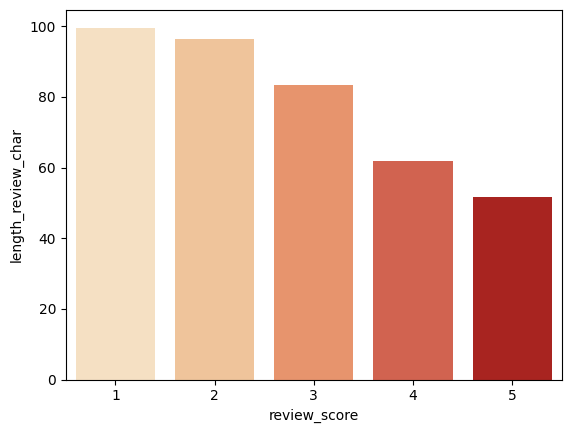

In [12]:
sns.barplot(
    data=average_length_reviews, 
    x = 'review_score', 
    y = 'length_review_char',
    palette = 'OrRd'
)

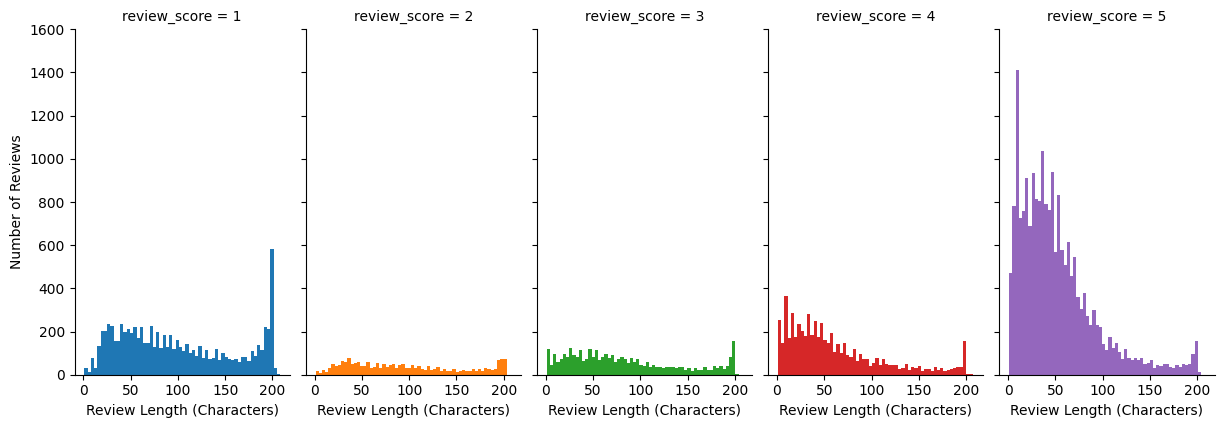

In [13]:
g = sns.FacetGrid(
    data=reviews_filtered, 
    col='review_score', 
    hue='review_score',
    
)
g.map(plt.hist, 'length_review_char', bins=60)
g.set_xlabels('Review Length (Characters)')
g.set_ylabels('Number of Reviews')
g.set(ylim=(0, 1600))
plt.gcf().set_size_inches(12, 5)

In [16]:
model1 = smf.ols(formula = 'review_score ~ length_review_char', data=reviews).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                 1.716e+04
Date:                Fri, 19 Jul 2024   Prob (F-statistic):               0.00
Time:                        14:30:36   Log-Likelihood:            -1.5974e+05
No. Observations:               98687   AIC:                         3.195e+05
Df Residuals:                   98685   BIC:                         3.195e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.4092      0.004    980.324      0.000       4.400       4.418
length_review_char    -0.0106   8.12e-05   -130.978      0.000      -0.011      -0.010
==============================================================================
Omnibus:                    16000.182   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25075.903
Skew:                          -1.158   Prob(JB):                         0.00
Kurtosis:                       3.856   Cond. No.                         64.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
model2 = smf.ols(formula = 'review_score ~ C(product_category_name)', data=reviews).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     11.12
Date:                Fri, 19 Jul 2024   Prob (F-statistic):          1.63e-119
Time:                        14:30:42   Log-Likelihood:            -1.6726e+05
No. Observations:               98687   AIC:                         3.347e+05
Df Residuals:                   98616   BIC:                         3.353e+05
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================================
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                               4.0726      0.099     41.334      0.000       3.880       4.266
C(product_category_name)[T.air_conditioning]                           -0.0049      0.129     -0.038      0.970      -0.258       0.248
C(product_category_name)[T.art]                                        -0.0219      0.136     -0.161      0.872      -0.289       0.245
C(product_category_name)[T.arts_and_craftmanship]                       0.1013      0.292      0.347      0.729      -0.471       0.674
C(product_category_name)[T.audio]                                      -0.2531      0.121     -2.089      0.037      -0.491      -0.016
C(product_category_name)[T.auto]                                        0.0460      0.101      0.457      0.648      -0.151       0.244
C(product_category_name)[T.baby]                                       -0.0074      0.102     -0.072      0.942      -0.206       0.192
C(product_category_name)[T.bed_bath_table]                             -0.1021      0.099     -1.027      0.304      -0.297       0.093
C(product_category_name)[T.books_general_interest]                      0.4454      0.115      3.879      0.000       0.220       0.670
C(product_category_name)[T.books_imported]                              0.3120      0.208      1.502      0.133      -0.095       0.719
C(product_category_name)[T.books_technical]                             0.3549      0.128      2.776      0.006       0.104       0.605
C(product_category_name)[T.cds_dvds_musicals]                           0.5940      0.393      1.511      0.131      -0.176       1.364
C(product_category_name)[T.christmas_supplies]                          0.0322      0.154      0.209      0.834      -0.270       0.334
C(product_category_name)[T.cine_photo]                                  0.2711      0.192      1.412      0.158      -0.105       0.647
C(product_category_name)[T.computers]                                   0.1015      0.140      0.728      0.467      -0.172       0.375
C(product_category_name)[T.computers_accessories]                      -0.0403      0.100     -0.404      0.686      -0.236       0.155
C(product_category_name)[T.consoles_games]                              0.0401      0.107      0.376      0.707      -0.169       0.249
C(product_category_name)[T.construction_tools_construction]             0.0326      0.110      0.297      0.766      -0.183       0.248
C(product_category_name)[T.construction_tools_lights]                   0.0708      0.130      0.546      0.585      -0.183       0.325
C(product_category_name)[T.construction_tools_safety]                  -0.1831      0.143  

In [18]:
from matplotlib.font_manager import findSystemFonts, FontProperties

In [19]:
reviews.head()

,review_id,review_score,length_review_words,length_review_char,review_comment_message,order_id,product_category_name
0,7bc2406110b926393aa56f80a40eba40,4,0,0,,73fc7af87114b39712e6da79b0a377eb,sports_leisure
1,80e641a11e56f04c1ad469d5645fdfde,5,0,0,,a548910a1c6147796b98fdf73dbeba33,computers_accessories
2,228ce5500dc1d8e020d8d1322874b6f0,5,0,0,,f9e4b658b201a9f2ecdecbb34bed034b,computers_accessories
3,e64fb393e7b32834bb789ff8bb30750e,5,6,37,Recebi bem antes do prazo estipulado.,658677c97b385a9be170737859d3511b,garden_tools
4,f7c4243c7fe1938f181bec41a392bdeb,5,15,100,Parabéns lojas lannister adorei comprar pela I...,8e6bfb81e283fa7e4f11123a3fb894f1,sports_leisure


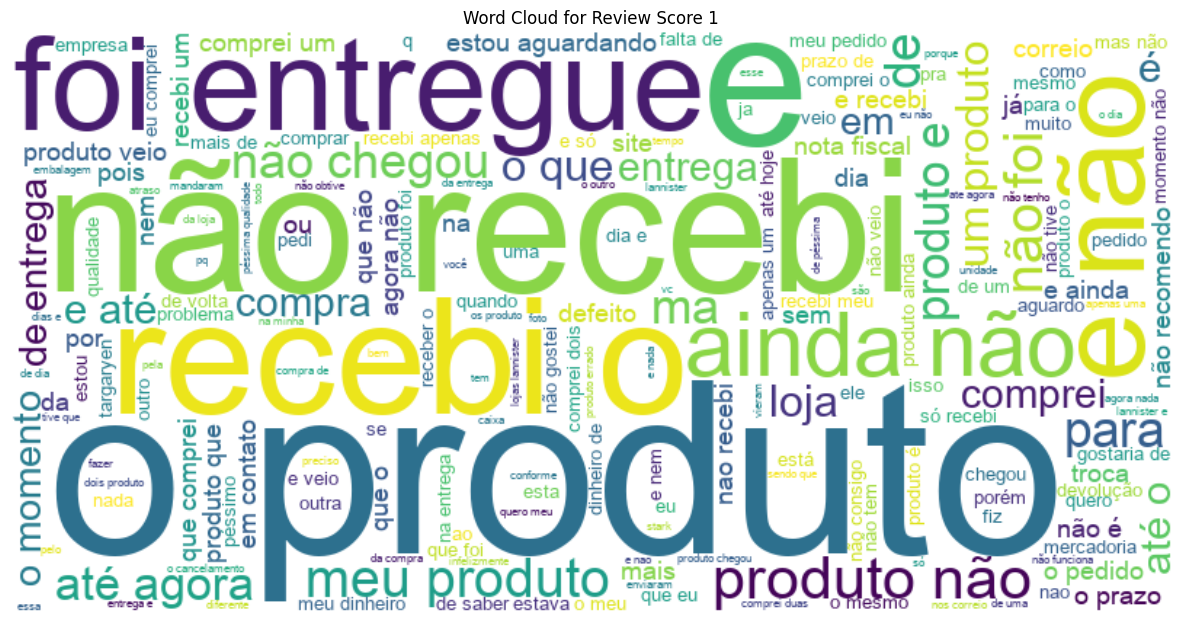

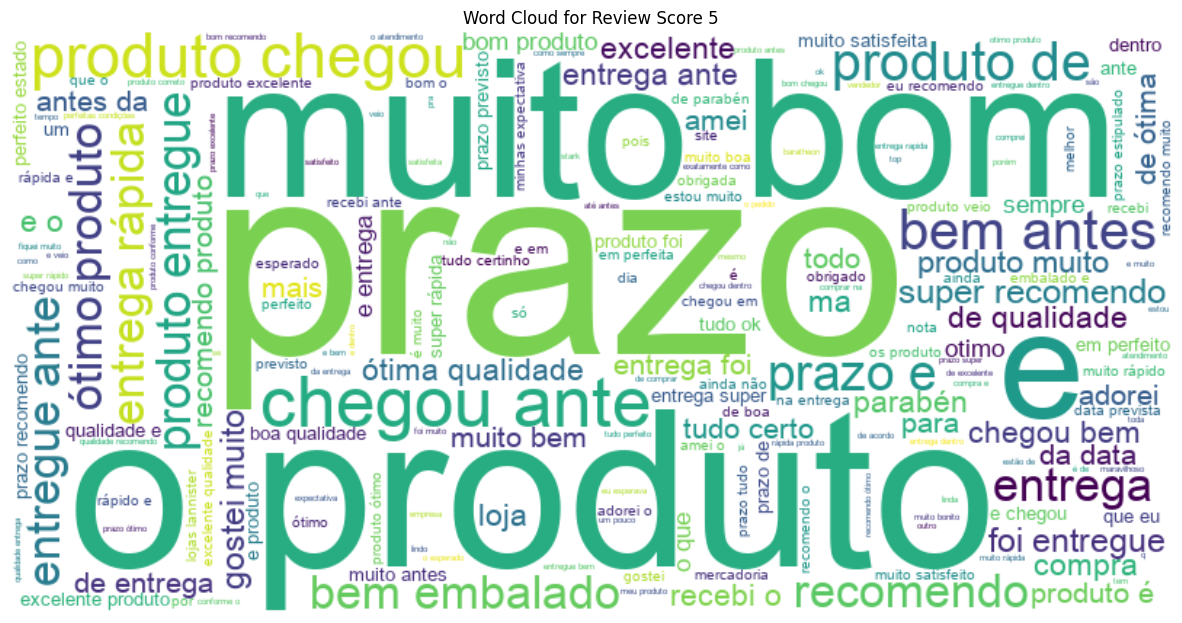

In [21]:
def preprocess_text(text):
    
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    return text

def generate_word_clouds_by_score(reviews, scores_to_plot):
    
    # Fill NaN values in 'review_comment_message' with an empty string
    reviews['review_comment_message'] = reviews['review_comment_message'].fillna("")
    
    # Preprocess the review comments
    reviews['clean_comment_message'] = reviews['review_comment_message'].apply(preprocess_text)
    
    # Group by 'review_score'
    grouped_reviews = reviews.groupby('review_score')['clean_comment_message'].apply(lambda x: ' '.join(x)).reset_index()
    
    # Filter for specific review scores
    grouped_reviews = grouped_reviews[grouped_reviews['review_score'].isin(scores_to_plot)]
    
    # Attempt to find Arial font or fallback to a default - Was getting TrueType fonts errors
    font_paths = fm.findSystemFonts(fontpaths=None, fontext='ttf')
    arial_fonts = [f for f in font_paths if 'Arial' in f]
    font_path = arial_fonts[0] if arial_fonts else None
    
    # Generate and plot a word cloud for each specified review score
    for _, row in grouped_reviews.iterrows():
        review_score = row['review_score']
        text = row['clean_comment_message']
        
        # Generate word cloud with or without font_path (to avoid TrueType errors)
        if font_path:
            wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(text)
        else:
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        
        # Plot the word cloud
        plt.figure(figsize=(15, 10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Review Score {review_score}')
        plt.show()


# Call the function to generate word clouds for review scores 1 and 5
generate_word_clouds_by_score(reviews, scores_to_plot=[1, 5])